# Rolling Regression

* [Pairs trading](https://www.quantopian.com/posts/pairs-trading-algorithm-1) is a famous technique in algorithmic trading that plays two stocks against each other.
* For this to work, stocks must be correlated (cointegrated).
* One common example is the price of gold (GLD) and the price of gold mining operations (GFI).

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

Lets load the prices of GFI and GLD.

In [2]:
# from pandas_datareader import data
# prices = data.GoogleDailyReader(symbols=['GLD', 'GFI'], end='2014-8-1').read().loc['Open', :, :]

prices = pd.read_csv(pm.get_data('stock_prices.csv')).dropna()
prices['Date'] = pd.DatetimeIndex(prices['Date'])
prices = prices.set_index('Date')
prices_zscored = (prices - prices.mean()) / prices.std()
prices.head()

,GFI,GLD
Date,,
2010-01-04,13.55,109.82
2010-01-05,13.51,109.88
2010-01-06,13.70,110.71
2010-01-07,13.63,111.07
2010-01-08,13.72,111.52


Plotting the prices over time suggests a strong correlation. However, the correlation seems to change over time.

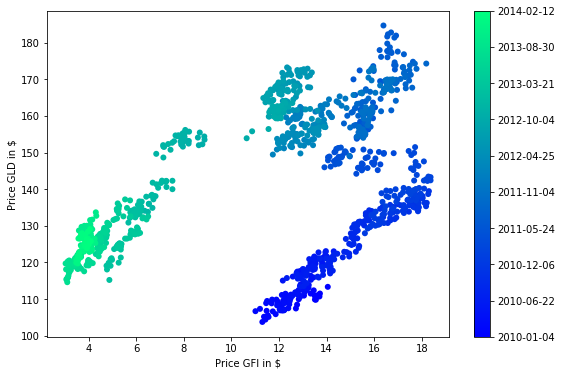

In [3]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, xlabel='Price GFI in \$', ylabel='Price GLD in \$')
colors = np.linspace(0.1, 1, len(prices))
mymap = plt.get_cmap("winter")
sc = ax.scatter(prices.GFI, prices.GLD, c=colors, cmap=mymap, lw=0)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in prices[::len(prices)//10].index]);

A naive approach would be to estimate a linear model and ignore the time domain.

In [4]:
with pm.Model() as model_reg:
    pm.glm.GLM.from_formula('GLD ~ GFI', prices)
    trace_reg = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, GFI, Intercept]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:09<00:00, 656.59draws/s]


The posterior predictive plot shows how bad the fit is.

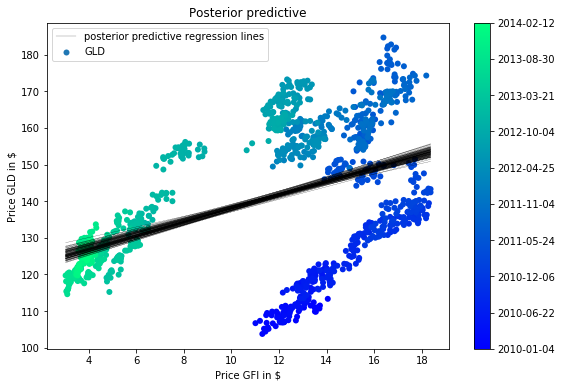

In [5]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, xlabel='Price GFI in \$', ylabel='Price GLD in \$', 
            title='Posterior predictive regression lines')
sc = ax.scatter(prices.GFI, prices.GLD, c=colors, cmap=mymap, lw=0)
pm.plot_posterior_predictive_glm(trace_reg[100:], samples=100, 
                              label='posterior predictive regression lines',
                              lm=lambda x, sample: sample['Intercept'] + sample['GFI'] * x,
                              eval=np.linspace(prices.GFI.min(), prices.GFI.max(), 100))
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in prices[::len(prices)//10].index]);
ax.legend(loc=0);

## Rolling regression

Next, we will build an improved model that will allow for changes in the regression coefficients over time. Specifically, we will assume that intercept and slope follow a random-walk through time. That idea is similar to the [stochastic volatility model](stochastic_volatility.ipynb).

$$ \alpha_t \sim \mathcal{N}(\alpha_{t-1}, \sigma_\alpha^2) $$
$$ \beta_t \sim \mathcal{N}(\beta_{t-1}, \sigma_\beta^2) $$

First, lets define the hyper-priors for $\sigma_\alpha^2$ and $\sigma_\beta^2$. This parameter can be interpreted as the volatility in the regression coefficients.

In [6]:
model_randomwalk = pm.Model()
with model_randomwalk:
    # std of random walk
    sigma_alpha = pm.Exponential('sigma_alpha', 50.)
    sigma_beta = pm.Exponential('sigma_beta', 50.)
    
    alpha = pm.GaussianRandomWalk('alpha', sigma=sigma_alpha, 
                                  shape=len(prices))
    beta = pm.GaussianRandomWalk('beta', sigma=sigma_beta, 
                                 shape=len(prices))       

Perform the regression given coefficients and data and link to the data via the likelihood.

In [7]:
with model_randomwalk:
    # Define regression
    regression = alpha + beta * prices_zscored.GFI
    
    # Assume prices are Normally distributed, the mean comes from the regression.
    sd = pm.HalfNormal('sd', sigma=.1)
    likelihood = pm.Normal('y', 
                           mu=regression, 
                           sigma=sd, 
                           observed=prices_zscored.GLD)

Inference. Despite this being quite a complex model, NUTS handles it wells.

In [9]:
with model_randomwalk:
    trace_rw = pm.sample(tune=2000, cores=4, 
                         target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, beta, alpha, sigma_beta, sigma_alpha]
Sampling 4 chains: 100%|██████████| 10000/10000 [17:33<00:00,  4.81draws/s]
The acceptance probability does not match the target. It is 0.6880391404482192, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9795619811576803, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin sta

Increasing the tree-depth does indeed help but it makes sampling very slow. The results look identical with this run, however.

## Analysis of results

As can be seen below, $\alpha$, the intercept, changes over time.

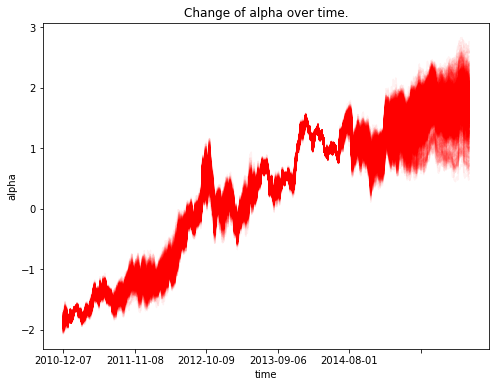

In [10]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111, xlabel='time', ylabel='alpha', title='Change of alpha over time.')
ax.plot(trace_rw['alpha'].T, 'r', alpha=.05);
ax.set_xticklabels([str(p.date()) for p in prices[::len(prices)//5].index]);

As does the slope.

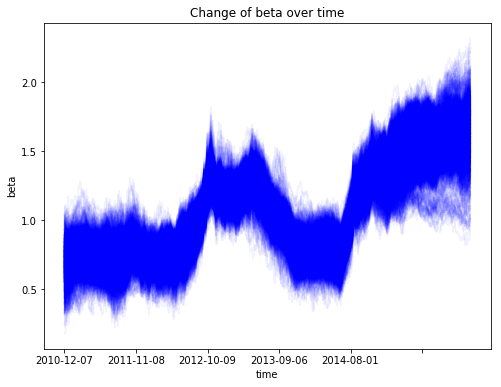

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlabel='time', ylabel='beta', title='Change of beta over time')
ax.plot(trace_rw['beta'].T, 'b', alpha=.05);
ax.set_xticklabels([str(p.date()) for p in prices[::len(prices)//5].index]);

The posterior predictive plot shows that we capture the change in regression over time much better. Note that we should have used returns instead of prices. The model would still work the same, but the visualisations would not be quite as clear.

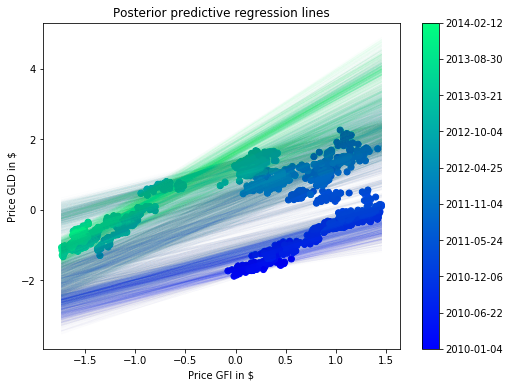

In [12]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlabel='Price GFI in \$', ylabel='Price GLD in \$', 
            title='Posterior predictive regression lines')

colors = np.linspace(0.1, 1, len(prices))
colors_sc = np.linspace(0.1, 1, len(trace_rw[::10]['alpha'].T))
mymap = plt.get_cmap('winter')
mymap_sc = plt.get_cmap('winter')

xi = np.linspace(prices_zscored.GFI.min(), prices_zscored.GFI.max(), 50)
for i, (alpha, beta) in enumerate(zip(trace_rw[::15]['alpha'].T, 
                                      trace_rw[::15]['beta'].T)):
    for a, b in zip(alpha[::30], beta[::30]):
        ax.plot(xi, a + b*xi, alpha=.01, lw=1, 
                c=mymap_sc(colors_sc[i]))
        
sc = ax.scatter(prices_zscored.GFI, prices_zscored.GLD, 
                label='data', cmap=mymap, c=colors)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in prices_zscored[::len(prices)//10].index]);
#ax.set(ylim=(100, 190));

Author: Thomas Wiecki